# Incompressible hyperelasticity as user potential or user residual

[Download this notebook](https://github.com/BodeTobias/AutoPDEx/tree/main/docs/notebooks/mixed_problem.ipynb)


In this example, we consider the same problem as in the quickstart example, but assume incompressible material behavior and non-homogeneous Dirichlet boundary conditions (instead of the load $q_0$). The incompressibility constraint is treated by means of the Lagrange multiplier method, leading to a mixed problem. The LBB conditions are taken into account by selecting a second-order approach for the displacement field and a continuous first-order approach for the pressure field. For the implementation, two versions are presented, based on a user potential and a user residual.

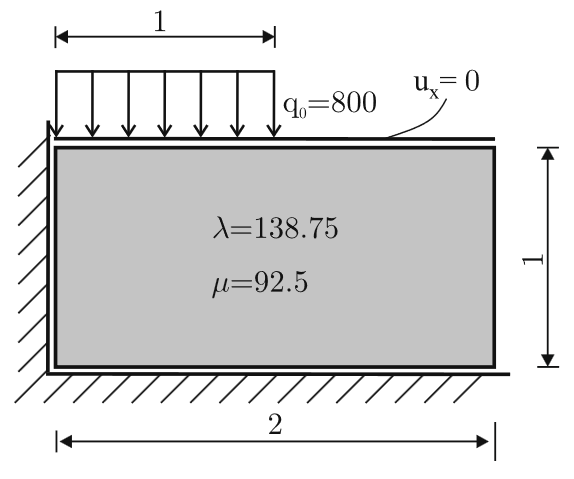

## Preprocessing

First, we do some imports and activate the double precision, since JAX is using single precsion by default.

In [1]:
import jax
import jax.numpy as jnp
import flax
import pygmsh
import meshio
import pyvista as pv

from autopdex import seeder, geometry, solver, utility, models, spaces

jax.config.update("jax_enable_x64", True)

Now, we generate a mesh using pygmsh. As element order for the displacement field we choose second order quadrilateral elements, for the pressure field we choose first order elements.

In [2]:
element_order = 2
L = 2.
H = 1.
pts = [[0., 0.], [L, 0.], [L, H], [0., H]]
with pygmsh.occ.Geometry() as geom:
    region = geom.add_polygon(pts, mesh_size=0.1)
    geom.set_recombined_surfaces([region.surface])
    displacement_mesh = geom.generate_mesh(order=element_order)
    pressure_mesh = geom.generate_mesh(order=element_order-1)


Let's get the relevant information from the mesh and make it to JAX arrays. We take the same set of elements for the Displacement and Pressure fields, but with reduced number of nodes for the pressure field. For the mixed approach, the degrees of freedom, The node coordinates and the connectivity have to be specified as dicts with consistent keywords.

In [3]:
n_dim = 2
displacement_node_coor = jnp.asarray(displacement_mesh.points[:,:n_dim])
pressure_node_coor = jnp.asarray(pressure_mesh.points[:,:n_dim])
node_coordinates = {'displacement': displacement_node_coor,
                    'pressure': pressure_node_coor}

displacement_connectivity = jnp.asarray([ v for k, v in displacement_mesh.cells_dict.items() if 'quad' in k])[0]
pressure_connectivity = jnp.asarray([ v for k, v in pressure_mesh.cells_dict.items() if 'quad' in k])[0]
connectivity = {'displacement': displacement_connectivity,
                'pressure': pressure_connectivity}


For Finite Elements, the Dirichlet conditions are usually imposed by direct nodal imposition. Therefore, we first have to find the concerning nodes. The selection of nodes can be done by means of smooth distance functions. For some primitives, the distance function can be found in the geometry module. The module also contains Rvachev-function operations which can be used for constructing user-defined distance functions. Here, we select the nodes that are close to the lines on which we want to impose the Dirichlet boundary conditions.

In [4]:
dirichlet_nodes_left = geometry.on_lines(displacement_node_coor, pts[0], pts[3])
dirichlet_nodes_bottom = geometry.on_lines(displacement_node_coor, pts[0], pts[1])
dirichlet_nodes_top = geometry.on_lines(displacement_node_coor, pts[2], pts[3])
dirichlet_nodes_top_left = geometry.on_lines(displacement_node_coor, [1.,1.], pts[3])

For using the nodal imposition of boundary conditions in autopdex, we have to provide it with a mask that defines which degrees of freedoms shall be constrained.

Below, we fix the displacement in x-direction at the left and top and in y-direction at the bottom by settings the concerning entries to True. On the upper left part of the boundary, we impose a vertical displacement of v.

In [5]:
selection_left = utility.dof_select(dirichlet_nodes_left, jnp.asarray([True, False]))
selection_bottom = utility.dof_select(dirichlet_nodes_bottom, jnp.asarray([False, True]))
selection_top = utility.dof_select(dirichlet_nodes_top, jnp.asarray([True, False]))
selection_top_left = utility.dof_select(dirichlet_nodes_top_left, jnp.asarray([False, True]))
dirichlet_dofs = {'displacement': selection_left + selection_bottom + selection_top + selection_top_left,
                  'pressure': jnp.zeros((pressure_node_coor.shape[0], 1), jnp.bool)}


Specify the values of the Dirichlet conditions at the Dirichlet nodes.

In [6]:
dirichlet_conditions = {'displacement': jnp.zeros_like(dirichlet_dofs['displacement'], jnp.float64),
                        'pressure': jnp.zeros_like(dirichlet_dofs['pressure'], jnp.float64)}

v = -0.2
dirichlet_conditions['displacement'] += utility.mask_set(dirichlet_conditions['displacement'], selection_top_left, v * jnp.ones(selection_top_left.sum()))



Now, we have to define the model. Integration on reference elements of mixed potentials and weak forms are already contained in the models module, but we need to specify the solution spaces (spaces.fem_iso_line_quad_brick), the integration point positions and weights (Gauß-Legendre) and the integrand function (potential or weak form).

In [7]:
def ansatz_spaces():
    return {'displacement': spaces.fem_iso_line_quad_brick,
            'pressure': spaces.fem_iso_line_quad_brick}

In [8]:
# For user potential
def integrand_fun(x_int, ansatz_fun, settings, static_settings, elem_number, set):
    # Kinematics (deformation gradient and its determinant)
    u_fun = ansatz_fun['displacement']
    H = jax.jacfwd(u_fun)(x_int)
    F = jnp.asarray([[H[0,0], H[0,1], 0.],
                     [H[1,0], H[1,1], 0.],
                     [0.,     0.,     0.]]) + jnp.identity(3)
    J = utility.matrix_det(F)

    # Strain energy function
    shear_modulus = 92.5
    potential = models.isochoric_neo_hooke(F, shear_modulus)
    
    # Add Lagrange multiplier term
    multiplier = ansatz_fun['pressure'](x_int)
    constraint =  (J - 1)
    potential += multiplier * constraint
    return potential

# # For user residual/ weak form
# def integrand_fun(x_int, trial_ansatz_fun, test_ansatz_fun, settings, static_settings, elem_number, set):
#     # Kinematics (deformation gradient and its determinant)
#     u_fun = trial_ansatz_fun['displacement']
#     virtual_u_fun = test_ansatz_fun['displacement']
#     virtual_u = virtual_u_fun(x_int)
#     virtual_H = jax.jacfwd(virtual_u_fun)(x_int)
#     virtual_F = jnp.asarray([[virtual_H[0,0],   virtual_H[0,1], 0.],
#                              [virtual_H[1,0],   virtual_H[1,1], 0.],
#                              [0.,               0.,             0.]])    
#     H = jax.jacfwd(u_fun)(x_int)
#     F = jnp.asarray([[H[0,0], H[0,1], 0.],
#                      [H[1,0], H[1,1], 0.],
#                      [0.,     0.,     0.]]) + jnp.identity(3)
#     J = utility.matrix_det(F)

#     # Piola-Kirchhoff stress and weak form
#     shear_modulus = 92.5
#     p = trial_ansatz_fun['pressure'](x_int)
#     virtual_p = test_ansatz_fun['pressure'](x_int)

#     P_iso = jax.jacrev(models.isochoric_neo_hooke)(F, shear_modulus)
#     P_vol = p * J * matrix_inv(F).T
#     P = P_iso + P_vol
#     weak_form = jnp.einsum("ij, ij", P, virtual_F)
    
#     # Add Lagrange multiplier term
#     constraint =  (J - 1)
#     weak_form += virtual_p * constraint
#     return weak_form

In [9]:
user_model = models.mixed_reference_domain_potential(
# user_model = models.mixed_reference_domain_residual(
    integrand_fun,
    ansatz_spaces(),
    *seeder.gauss_legendre_nd(dimension = 2, order = 2 * element_order),
    'displacement')


Finally, we have defined the boundary value problem and have to put it in a form suitable for autopdex to proceed, i.e. the dictionaries static_settings and settings.


In [10]:
static_settings = flax.core.FrozenDict({
  'assembling mode': ('user potential',),
  # 'assembling mode': ('user residual',),
  'solution structure': ('nodal imposition',),
  'model': (user_model, ),
  'solver type': 'newton',
  'solver backend': 'scipy',
  'solver': 'lapack',
  'verbose': -1,
})
settings = {
  'connectivity': (connectivity,),
  'dirichlet dofs': dirichlet_dofs,
  'node coordinates': {'displacement': displacement_node_coor,
                       'pressure': pressure_node_coor},
  'dirichlet conditions': dirichlet_conditions,
}

## Analysis


Compile and run the adaptive load stepping.

In [11]:
def multiplier_settings(settings, multiplier):
    settings['dirichlet conditions']['displacement'] = multiplier * dirichlet_conditions['displacement']
    return settings
dofs_0 = utility.dict_zeros_like(dirichlet_dofs, dtype=jnp.float64)
dofs = solver.adaptive_load_stepping(dofs_0, settings, static_settings, multiplier_settings)[0]

Sensitivity analysis w.r.t. boundary conditions


In [12]:
@jax.jit
def diffable_solve(bc_scaler, settings):
    settings['bc scaler'] = bc_scaler
    def multiplier_settings(settings, multiplier):
        settings['dirichlet conditions']['displacement'] = multiplier * dirichlet_conditions['displacement'] * settings['bc scaler']
        return settings
    return solver.adaptive_load_stepping(dofs_0, settings, static_settings, multiplier_settings, path_dependent=False, implicit_diff_mode='forward')[0]

compute_sensitivities = jax.jit(jax.jacfwd(diffable_solve))
du_dbc = compute_sensitivities(1.0, settings)

## Postprocessing


Export as .vtk for Paraview

In [13]:
mesh = displacement_mesh
points = mesh.points
cells = jnp.asarray([ v for k, v in mesh.cells_dict.items() if 'quad' in k])[0]
mesh = meshio.Mesh(
    points,
    {'quad': cells[:,:4]},
    point_data={
        "u": jnp.pad(dofs['displacement'], ((0, 0), (0, 1)), constant_values=0),
        "du_dBC": jnp.pad(du_dbc['displacement'], ((0, 0), (0, 1)), constant_values=0),
    },
)
mesh.write("./punch_test.vtk")


Visualization with Pyvista

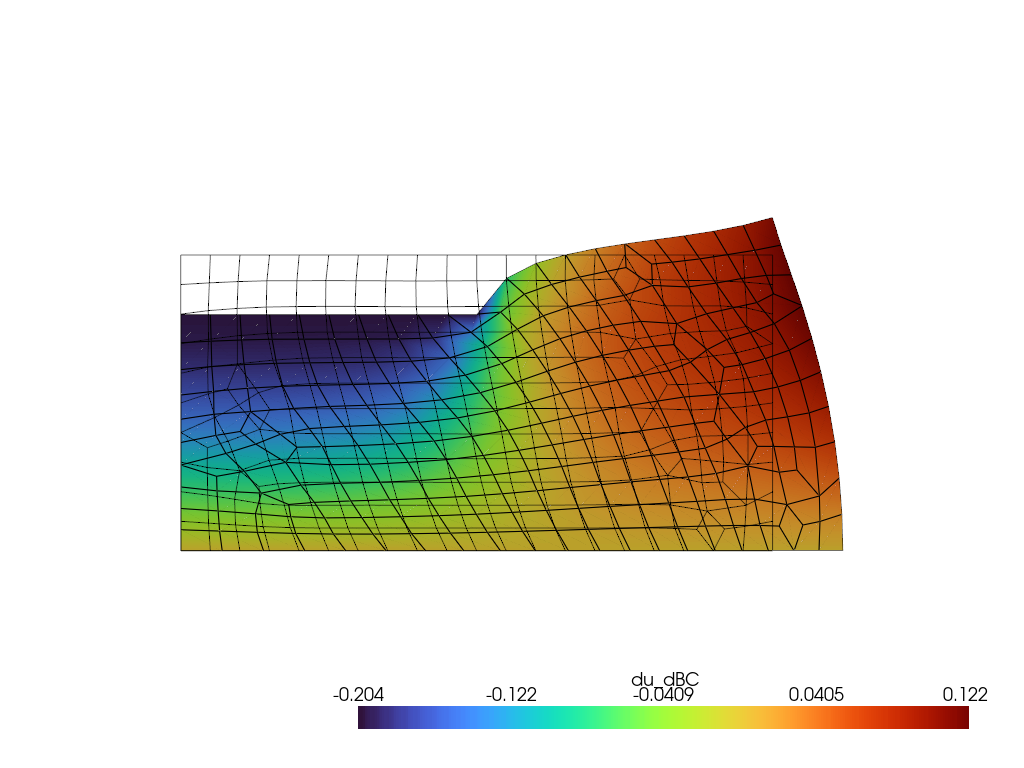

In [14]:
pv.set_jupyter_backend('static')
plotter = pv.Plotter()
pv_mesh = pv.read("./punch_test.vtk")
warped_mesh = pv_mesh.warp_by_vector('u')
plotter.add_mesh(warped_mesh, scalars='du_dBC', component=1, show_edges=True, cmap='turbo')
plotter.add_mesh(pv_mesh, style='wireframe', color='black')
plotter.view_xy()
plotter.show()